In [29]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [2]:
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
pixel_data = data['pixels']
label_data = data['emotion']

In [5]:
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype=np.uint8, sep=' ')
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = img.reshape(48,48,3)
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    #img = expand_greyscale_image_channels(img)
    #b,g,r = cv2.split(img)
    #img = cv2.merge([r,g,b])
    images.append(img)

  X = np.array(images)

 

  return X

In [6]:
oversampler = RandomOverSampler(sampling_strategy='auto')

X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)

X_over_series = pd.Series(X_over.flatten())

In [7]:
X = preprocess_pixels(X_over_series)
Y = Y_over
Y = Y.values.reshape(-1,1)

In [8]:
print("Images shape = ",X.shape,"\nLabels shape = ",Y.shape)
print(type(X),type(Y))

Images shape =  (62923, 48, 48, 3) 
Labels shape =  (62923, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


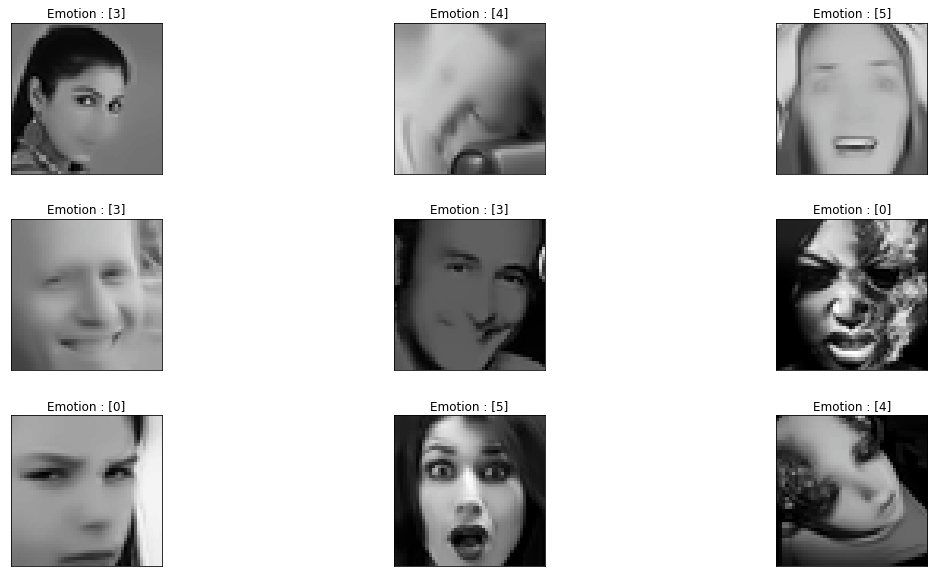

In [9]:
def display_rand_images(images, labels):
    
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Emotion : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(X, Y)
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [10]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(X.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(45)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [    0     1     2 ... 62920 62921 62922]

'n' values after shuffling =  [62634  6425 11709 ...  6012  6558 56267]


In [11]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
X = X[n]
Y = Y[n]

print("Images shape after shuffling = ",X.shape,"\nLabels shape after shuffling = ",Y.shape)

Images shape after shuffling =  (62923, 48, 48, 3) 
Labels shape after shuffling =  (62923, 1)


In [12]:
X = X.astype(np.float32)
Y = Y.astype(np.int32)
X = X/255
print("Images shape after normalization = ",X.shape)

Images shape after normalization =  (62923, 48, 48, 3)


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 45)

X_val = X_train[:12585]
Y_val = Y_train[:12585]
X_train = X_train[12585:]
Y_train = Y_train[12585:]

print("x_train shape = ",X_train.shape)
print("y_train shape = ",Y_train.shape)
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",Y_test.shape)

print("\nx_val shape = ",X_val.shape)
print("y_val shape = ",Y_val.shape)

x_train shape =  (37753, 48, 48, 3)
y_train shape =  (37753, 1)

x_test shape =  (12585, 48, 48, 3)
y_test shape =  (12585, 1)

x_val shape =  (12585, 48, 48, 3)
y_val shape =  (12585, 1)


In [14]:
y_train = to_categorical(Y_train, num_classes=7)
y_test = to_categorical(Y_test, num_classes=7)
y_val = to_categorical(Y_val, num_classes=7)

In [15]:
y_train.shape, y_test.shape, y_val.shape

((37753, 7), (12585, 7), (12585, 7))

In [16]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=X_train[0].shape, include_top=False, weights="imagenet")

58900480/58889256 [==============================] - 0s 0us/step


In [17]:
model = tf.keras.models.Sequential()

model.add(pre_trained_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(7, activation='softmax'))

In [18]:
pre_trained_model.trainable = True
set_trainable = False
for layer in pre_trained_model.layers:
    print(layer.name)
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14,980,935
Trainable params: 7,345,671
Non-trainable params: 7,635,264
_________________________________________________________________


In [20]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [22]:
X_train.shape,y_train.shape

((37753, 48, 48, 3), (37753, 7))

In [23]:
start_time = time.time()

history = model.fit(X_train, y_train,
    epochs = 15,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=1)

print("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/15
1180/1180 [==============================] - 1757s 1s/step - loss: 1.4023 - accuracy: 0.4608 - val_loss: 1.1819 - val_accuracy: 0.5411
Epoch 2/15
1180/1180 [==============================] - 1668s 1s/step - loss: 1.0222 - accuracy: 0.6113 - val_loss: 1.0395 - val_accuracy: 0.6065
Epoch 3/15
1180/1180 [==============================] - 1733s 1s/step - loss: 0.7943 - accuracy: 0.7118 - val_loss: 0.9504 - val_accuracy: 0.6576
Epoch 4/15
1180/1180 [==============================] - 1757s 1s/step - loss: 0.5615 - accuracy: 0.8025 - val_loss: 0.8718 - val_accuracy: 0.7167
Epoch 5/15
1180/1180 [==============================] - 1738s 1s/step - loss: 0.3674 - accuracy: 0.8728 - val_loss: 0.8926 - val_accuracy: 0.7317
Epoch 6/15
1180/1180 [==============================] - 1749s 1s/step - loss: 0.2388 - accuracy: 0.9195 - val_loss: 1.0412 - val_accuracy: 0.7286
Epoch 7/15
1180/1180 [==============================] - 1782s 2s/step - loss: 0.1690 - accuracy: 0.9446 - val_loss: 1.0354 -

In [27]:
model_json = model.to_json()
with open("VGG16_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("VGG16_Classifier.h5")
print("Saved model to disk")
model.save_weights("VGG16.h5")

Saved model to disk


In [25]:
loss, accuracy = model.evaluate(X_test,y_test)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

394/394 [==============================] - 294s 747ms/step - loss: 1.3765 - accuracy: 0.7641
test_loss: 137.65
test_accuracy: 76.41


In [26]:
model_probs = model.predict(X_test,verbose=0)
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

Accuracy: 76.41
F1 score: 76.43
Precision: 76.71
Recall: 76.41


Text(69.0, 0.5, 'True_Label')

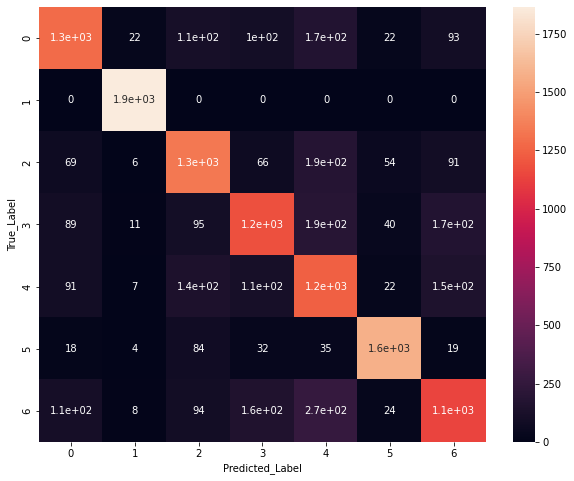

In [32]:
cf_matrix = confusion_matrix(y_test_reduced, model_classes)

plt.figure(figsize = (10,8))
sns.heatmap(cf_matrix, annot=True)
plt.xlabel('Predicted_Label')
plt.ylabel('True_Label')